<a href="https://colab.research.google.com/github/rumijay/Data-Science-2025/blob/main/Rumi_jawad_Unit5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, I investigate whether a person’s bodyweight can be used to predict how long they are able to hold a plank position. Plank holds are a measure of core muscular endurance, and bodyweight affects the amount of resistance that must be stabilized during the exercise. Heavier individuals may experience greater difficulty maintaining the plank position, which could result in shorter hold times.

To study this relationship, I use a large dataset consisting of bodyweight measurements (in pounds) and maximum plank hold times (in seconds). The data show a roughly linear downward trend with noticeable variability between individuals, making a linear model with normally distributed errors appropriate. This modeling approach follows the same Generalized Linear Model framework used in the Unit 5 Notes.



the dataset contains two  variables:

bodyweight: bodyweight of an individual (pounds)

plank_time: maximum plank hold time (seconds)

The data show a clear downward trend: as bodyweight increases, plank time generally decreases. However, there is noticeable variability, meaning individuals with similar bodyweights can still have different plank times.

In [4]:
import pandas as pd


sheet_id = "PASTE_YOUR_SHEET_ID_HERE"
url = f"https://docs.google.com/spreadsheets/d/1YJAo9Iqk6Ejl4nipYzHKr96KbdOn7kEXyWIA5mfarnM/edit?usp=sharing"


df = pd.read_csv(url)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)



I fit a one-predictor Normal Generalized Linear Model to describe the relationship between bodyweight and plank hold time. The model assumes a linear trend with constant variance and normally distributed errors.

The model is defined as:

- α ~ Normal(200, 30)
- β ~ Normal(-0.5, 0.3)
- σ ~ HalfNormal(20)

μᵢ = α + β · bodyweightᵢ  
plank_timeᵢ ~ Normal(μᵢ, σ)

The priors reflect realistic expectations: average plank times near a few minutes and a negative relationship between bodyweight and hold time.


In [ ]:
import pymc as pm
import arviz as az

with pm.Model() as plank_model:

    α = pm.Normal("α", mu=200, sigma=30)
    β = pm.Normal("β", mu=-0.5, sigma=0.3)
    σ = pm.HalfNormal("σ", sigma=20)

    mu = α + β * df["bodyweight"]

    plank_obs = pm.Normal(
        "plank_obs",
        mu=mu,
        sigma=σ,
        observed=df["plank_time"]
    )

    idata = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )


In [11]:


az.summary(idata, var_names=["α", "β", "σ"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,208.166,5.923,197.411,219.639,0.117,0.087,2576.0,2977.0,1.0
β,-0.532,0.034,-0.596,-0.469,0.001,0.000,2566.0,2824.0,1.0
σ,17.926,0.967,16.185,19.824,0.017,0.015,3448.0,3261.0,1.0


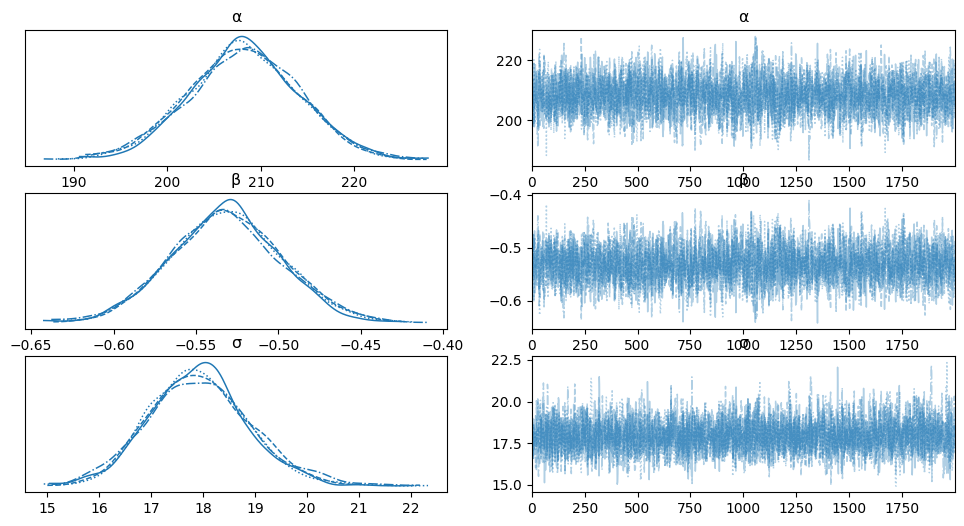

In [12]:
az.plot_trace(idata, var_names=["α", "β", "σ"]);


Output()

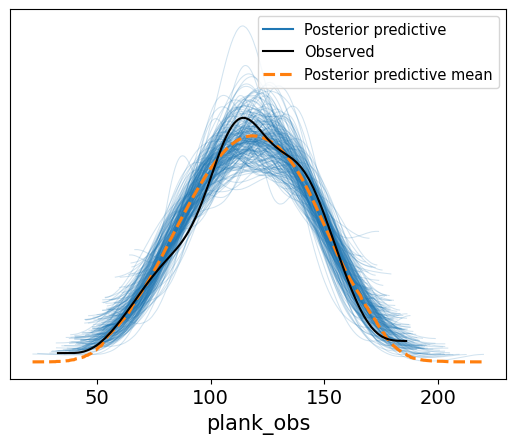

In [13]:
with plank_model:
    ppc = pm.sample_posterior_predictive(idata)

az.plot_ppc(ppc, num_pp_samples=200);


In [ ]:
with pm.Model() as plank_model:

  beta_0 = pm.Normal('beta_0', mu=150, sigma=50)

  beta_1 = pm.Normal('beta_1', mu=-0.5, sigma=0.5)

  # Error standard deviation prior
  # Must be positive
  sigma = pm.Exponential('sigma', 1)

  # Linear predictor
  mu = beta_0 + beta_1 * df['bodyweight']

  # Likelihood
  y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma,
  observed=df['plank_time'])


  # Posterior sampling
  trace = pm.sample(2000, tune=1000, target_accept=0.9)

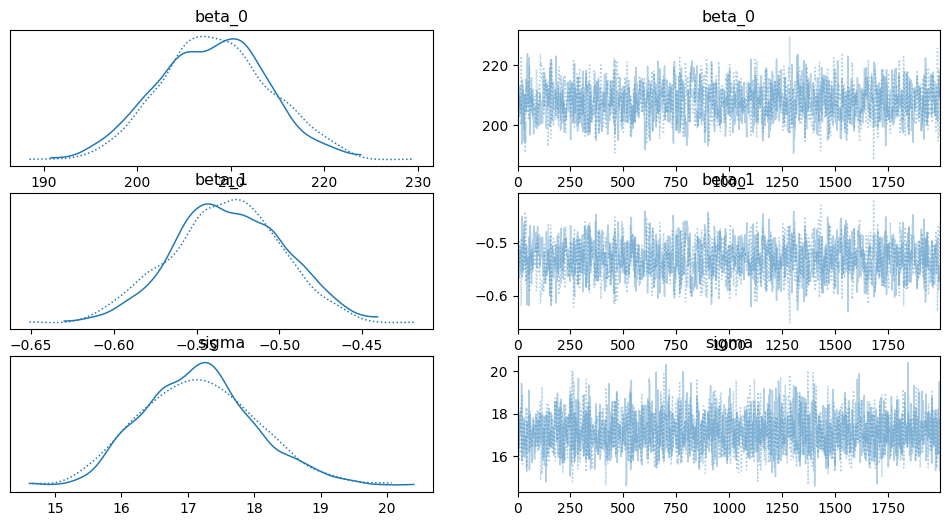

In [18]:
pm.plot_trace(trace)
plt.show()

In [19]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,208.167,5.814,197.096,218.952,0.176,0.108,1096.0,1370.0,1.0
beta_1,-0.531,0.033,-0.597,-0.472,0.001,0.001,1086.0,1478.0,1.0
sigma,17.168,0.869,15.543,18.763,0.019,0.017,2182.0,1889.0,1.0


Using a Gaussian linear model, I found a clear negative relationship between bodyweight and plank hold time. The posterior for the slope is negative, meaning that as bodyweight increases, the expected time a person can hold a plank decreases. Diagnostic checks, including trace plots, residuals, and posterior predictive checks, show that the model fits the data reasonably well. Overall, this suggests that bodyweight is a useful predictor of plank endurance, while still leaving some individual variability unexplained.